# SVM classification model for predicting COVID-19 severity using single-cell RNA sequencing data 

## Code written by: Sarah Bi

April 22, 2022 

BMED 8813 BHI

## Import libaries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split # to split data into training and testing
from sklearn.svm import SVC
from sklearn import metrics # to calculate accuracy of model
import collections
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

## Load data

### Load testing data

In [2]:
# Load testing data (3 patients)
X_test = pd.read_csv('split_data/test-data.csv')
y_test = pd.read_csv('split_data/test-data-labels.csv')

In [3]:
# Convert the text labels to numerical labels
# In this case, we will say 0=normal, 1=mild, 2=severe
y_test['type']=y_test['type'].replace('Normal',0)
y_test['type']=y_test['type'].replace('Mild', 1)
y_test['type']=y_test['type'].replace('Severe', 2)

In [4]:
# Save feature names before turning dataframe into numpy array 
feature_names = list(X_test.drop(columns=['Unnamed: 0']).columns)

In [5]:
# Drop unnecessary columns
X_test = np.array(X_test.drop(columns=['Unnamed: 0'])) # dataset is all the data expect for the first column containing the identifier information
y_test = np.array(y_test.drop(columns=['Unnamed: 0']))
y_test = np.reshape(y_test, (y_test.shape[0],)) # reshape the data to be (n,) instead of (n,1)

In [6]:
# Print shapes of testing dataset 
print("Testing data size:", X_test.shape)
print("Testing labels size:", y_test.shape)

Testing data size: (5608, 1999)
Testing labels size: (5608,)


### Load training data 

In [7]:
# Load training data (one patient at a time)
num_folds = 10
X_train = [[] for x in range(num_folds)] # make list of arrays to hold X data for each patient
y_train = [[] for x in range(num_folds)] # make list of arrays to hold y data for each patient
for i in range(num_folds):
    X_filename = 'split_data/train-data_' + str(i+1) + '.csv'
    y_filename = 'split_data/train-data-labels_' + str(i+1) + '.csv'

    X_train_temp = pd.read_csv(X_filename)
    y_train_temp = pd.read_csv(y_filename)

    # Convert the text labels to numerical labels
    # In this case, we will say 0=normal, 1=mild, 2=severe
    y_train_temp['type'] = y_train_temp['type'].replace('Normal', 0)
    y_train_temp['type'] = y_train_temp['type'].replace('Mild', 1)
    y_train_temp['type'] = y_train_temp['type'].replace('Severe', 2)

    # Drop unnecessary columns
    X_train_temp = np.array(X_train_temp.drop(columns=['Unnamed: 0']))  # dataset is all the data expect for the first column containing the identifier information
    y_train_temp = np.array(y_train_temp.drop(columns=['Unnamed: 0']))
    y_train_temp = np.reshape(y_train_temp, (y_train_temp.shape[0],))  # reshape the data to be (n,) instead of (n,1)

    X_train[i] = X_train_temp
    y_train[i] = y_train_temp

In [8]:
# Print shapes of training dataset
for i in range(num_folds): 
    print("Patient " + str(i+1) + " data size:", X_train[i].shape)
    print("Patient " + str(i+1) + " label size:", y_train[i].shape)
    print('\n')

Patient 1 data size: (377, 1999)
Patient 1 label size: (377,)


Patient 2 data size: (86, 1999)
Patient 2 label size: (86,)


Patient 3 data size: (383, 1999)
Patient 3 label size: (383,)


Patient 4 data size: (3858, 1999)
Patient 4 label size: (3858,)


Patient 5 data size: (347, 1999)
Patient 5 label size: (347,)


Patient 6 data size: (4818, 1999)
Patient 6 label size: (4818,)


Patient 7 data size: (5253, 1999)
Patient 7 label size: (5253,)


Patient 8 data size: (1672, 1999)
Patient 8 label size: (1672,)


Patient 9 data size: (224, 1999)
Patient 9 label size: (224,)


Patient 10 data size: (563, 1999)
Patient 10 label size: (563,)




# Training cell-level classification

## 1. Baseline classifier

### Train and validate model

In [9]:
# Create lists to store results from each fold 
f1_values = []
feature_importance_values = []

# Perform 10-fold cross validation with random forest
for i in range(num_folds):
    print("Fold", i) 
    X_cv_test = X_train[i]
    y_cv_test = y_train[i]
    print("Testing data size:", X_cv_test.shape)
    print("Testing label size:", y_cv_test.shape) 
    
    X_cv_train = X_train[:i] + X_train[i+1 :]
    X_cv_train = np.concatenate(X_cv_train, axis=0) # convert list of np arrays to single np array
    y_cv_train = y_train[:i] + y_train[i+1 :]
    y_cv_train = np.concatenate(y_cv_train, axis=0)
    print("Training data size:", X_cv_train.shape)
    print("Training label size:", y_cv_train.shape) 

    # Build SVC model
    # clf = LinearSVC(dual=False, class_weight='balanced') # create SVC classifier object
    clf = SVC(kernel='linear', class_weight='balanced')
    clf.fit(X_cv_train, y_cv_train)  # train the model using cross validation training set (9 patients)
    cv_pred = clf.predict(X_cv_test)  # predict using cross validation testing set (1 patient)
    
    # mcc = metrics.matthews_corrcoef(y_cv_test, cv_pred)
    # mcc_values.append(mcc)
    f1 = f1_score(y_cv_test, cv_pred, average='weighted')
    f1_values.append(f1)
    print("f1 score:", f1) 

    # Print other metrics
    # target_names = ['Label 0 (Normal)', 'Label 1 (Mild)', 'Label 2 (Severe)']
    # print("Classification Report") 
    # print(classification_report(y_cv_test, cv_pred, target_names=target_names))
    
    print("Real labels:", collections.Counter(y_cv_test)) 
    print("Predicted labels:", collections.Counter(cv_pred)) 
    
    # Print confusion matrix
    print("Confusion Matrix") 
    print(confusion_matrix(y_cv_test, cv_pred))

    print("\n") 
    
    # Save feature importance values from each fold 
    feature_importance_values.append(np.mean([clf.coef_[0], clf.coef_[1], clf.coef_[2]], axis=0))


Fold 0
Testing data size: (377, 1999)
Testing label size: (377,)
Training data size: (17204, 1999)
Training label size: (17204,)
f1 score: 0.6511627906976745
Real labels: Counter({2: 377})
Predicted labels: Counter({2: 182, 0: 106, 1: 89})
Confusion Matrix
[[  0   0   0]
 [  0   0   0]
 [106  89 182]]


Fold 1
Testing data size: (86, 1999)
Testing label size: (86,)
Training data size: (17495, 1999)
Training label size: (17495,)
f1 score: 0.49122807017543857
Real labels: Counter({1: 86})
Predicted labels: Counter({0: 32, 1: 28, 2: 26})
Confusion Matrix
[[ 0  0  0]
 [32 28 26]
 [ 0  0  0]]


Fold 2
Testing data size: (383, 1999)
Testing label size: (383,)
Training data size: (17198, 1999)
Training label size: (17198,)
f1 score: 0.7275747508305647
Real labels: Counter({2: 383})
Predicted labels: Counter({2: 219, 0: 105, 1: 59})
Confusion Matrix
[[  0   0   0]
 [  0   0   0]
 [105  59 219]]


Fold 3
Testing data size: (3858, 1999)
Testing label size: (3858,)
Training data size: (13723, 199

### Calculate results

In [10]:
# Calculate final performance metric
f1_final = np.mean(f1_values)
print("Final f1 score:", f1_final) 

Final f1 score: 0.5721243120812514


In [11]:
# Calculate and plot final feature importance scores
feature_importance_final = np.mean(feature_importance_values, axis=0)
feature_imp = pd.Series(feature_importance_final, index=feature_names).sort_values(ascending=False) # sort features by their feature importance score, in descending order
top_feature_imp = feature_imp.head(15)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


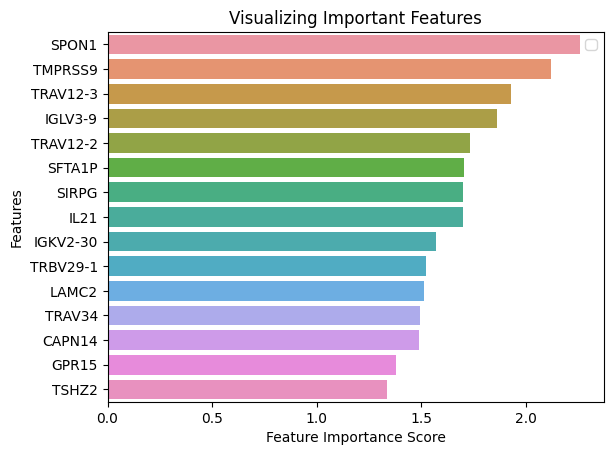

In [12]:
# Plot feature importance
import seaborn as sns
# %matplotlib inline
sns.barplot(x=top_feature_imp, y=top_feature_imp.index) # creating a bar plot of feature importance

# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

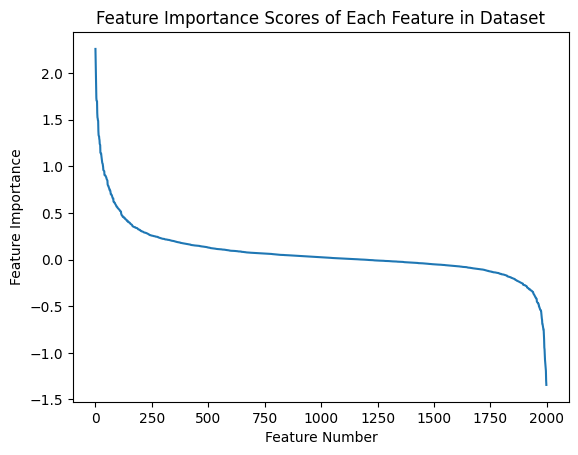

In [13]:
# Plot feature importance scores 
numbers = np.arange(len(feature_imp))
plt.plot(numbers, feature_imp)
plt.xlabel("Feature Number")
plt.ylabel("Feature Importance")
plt.title("Feature Importance Scores of Each Feature in Dataset")
plt.show()

In [14]:
# Find exact elbow of the plot above 
# %pip install kneed
from kneed import KneeLocator
kn = KneeLocator(numbers, feature_imp, curve='convex', direction='decreasing')
print("Elbow point:", kn.knee)

Elbow point: 41


## 2. Classifier trained on top n features

In [15]:
# Get features to retain
df = pd.read_csv('split_data/test-data.csv')
df = df.drop(columns=['Unnamed: 0'])
keep_data = feature_imp.head(kn.knee)
keep_names = list(keep_data.index)  # get names of the top n features to keep
index = df.columns.get_indexer(keep_names)  # find index of the top n features in the dataset

### Train and validate model

In [16]:
f1_select_values = []
feature_importance_select_values = []

for i in range(num_folds):
    print("Fold", i) 

    # Cross validation testing data
    X_select_cv_test = X_train[i]
    y_select_cv_test = y_train[i]
    X_select_cv_test = X_select_cv_test[:, index] # retain only the top n features in the data
    print("Testing data size:", X_select_cv_test.shape)
    print("Testing label size:", y_select_cv_test.shape) 

    # Cross validation training data
    X_select_cv_train = X_train[:i] + X_train[i+1 :]
    X_select_cv_train = np.concatenate(X_select_cv_train, axis=0) # convert list of np arrays to single np array
    X_select_cv_train = X_select_cv_train[:, index]
    y_select_cv_train = y_train[:i] + y_train[i+1 :]
    y_select_cv_train = np.concatenate(y_select_cv_train, axis=0)
    print("Training data size:", X_select_cv_train.shape)
    print("Training label size:", y_select_cv_train.shape) 

    # Build SVC model
    clf_select = SVC(kernel='linear', class_weight='balanced')
    clf_select.fit(X_select_cv_train, y_select_cv_train)  # train the model using cross validation training set (9 patients)
    cv_select_pred = clf_select.predict(X_select_cv_test)  # predict using cross validation testing set (1 patient)

    # Calculate f1 score 
    f1_select = f1_score(y_select_cv_test, cv_select_pred, average='weighted')
    f1_select_values.append(f1_select)
    print("f1 score:", f1_select)
    feature_importance_select_values.append(np.mean([clf_select.coef_[0], clf_select.coef_[1], clf_select.coef_[2]], axis=0))
        
    print("Real labels:", collections.Counter(y_select_cv_test)) 
    print("Predicted labels:", collections.Counter(cv_select_pred)) 
    
    # Print confusion matrix
    print("Confusion Matrix") 
    print(confusion_matrix(y_select_cv_test, cv_select_pred))

    print("\n") 

Fold 0
Testing data size: (377, 41)
Testing label size: (377,)
Training data size: (17204, 41)
Training label size: (17204,)
f1 score: 0.8796433878157505
Real labels: Counter({2: 377})
Predicted labels: Counter({2: 296, 1: 55, 0: 26})
Confusion Matrix
[[  0   0   0]
 [  0   0   0]
 [ 26  55 296]]


Fold 1
Testing data size: (86, 41)
Testing label size: (86,)
Training data size: (17495, 41)
Training label size: (17495,)
f1 score: 0.5043478260869565
Real labels: Counter({1: 86})
Predicted labels: Counter({2: 37, 1: 29, 0: 20})
Confusion Matrix
[[ 0  0  0]
 [20 29 37]
 [ 0  0  0]]


Fold 2
Testing data size: (383, 41)
Testing label size: (383,)
Training data size: (17198, 41)
Training label size: (17198,)
f1 score: 0.9286713286713287
Real labels: Counter({2: 383})
Predicted labels: Counter({2: 332, 1: 26, 0: 25})
Confusion Matrix
[[  0   0   0]
 [  0   0   0]
 [ 25  26 332]]


Fold 3
Testing data size: (3858, 41)
Testing label size: (3858,)
Training data size: (13723, 41)
Training label s

### Calculate results 

In [17]:
# Calculate final performance metric
f1_select_final = np.mean(f1_select_values)
print("Final f1 score:", f1_select_final) 

Final f1 score: 0.7367540377580679


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


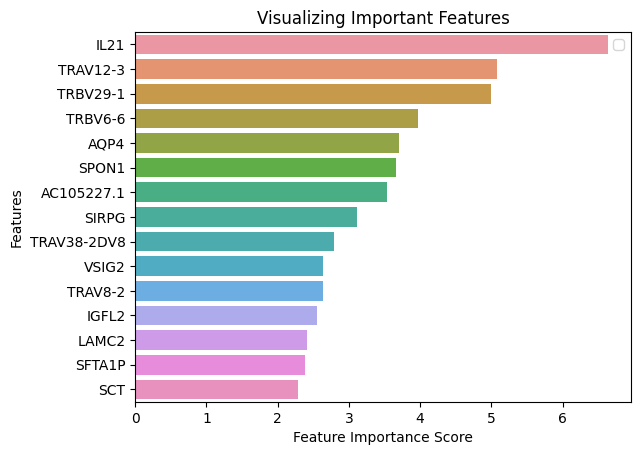

In [18]:
# Calculate and plot final feature importance scores
feature_importance_select_final = np.mean(feature_importance_select_values, axis=0)
feature_imp_select = pd.Series(feature_importance_select_final, index=keep_names).sort_values(ascending=False) # sort features by their feature importance score, in descending order
top_feature_imp_select = feature_imp_select.head(15)

# Plot feature importance
import seaborn as sns
# %matplotlib inline
sns.barplot(x=top_feature_imp_select, y=top_feature_imp_select.index) # creating a bar plot of feature importance

# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Final cell-level classifier 
Do not run until we determine what is the best cell-level classifier 

Evaluate performance on on entire training set (all 10 patients at once). Don't do cross validation. Run training on all 10 patients at once. Then perform testing on 3 test patients 

In [19]:
# Merge data for all patients into one training set instead of 10 indiviual ones 
X_train_total = np.concatenate(X_train, axis=0)
X_train_total = X_train_total[:, index]
y_train_total = np.concatenate(y_train, axis=0)
print("Training data size:", X_train_total.shape)
print("Training label size:", y_train_total.shape)

Training data size: (17581, 41)
Training label size: (17581,)


In [20]:
#################################################################
## Replace clf with name of final cell-level classifier to use ## 
#################################################################

# Perform training 
clf_final = SVC(kernel='linear', class_weight='balanced')
clf_final.fit(X_train_total, y_train_total) # change clf to something else if needed

SVC(class_weight='balanced', kernel='linear')

In [21]:
#################################################################
## Replace clf with name of final cell-level classifier to use ## 
#################################################################

# Make predictions for each patient
# test_pred = clf_final.predict(X_test) # predict one patient at a time, change clf to something else if needed
# f1_test = f1_score(y_test, test_pred, average='weighted')
# print("f1 score:", f1_test) 

In [22]:
# What happens if we trim X_test to only top features? 
X_test_trim = X_test[:, index]
test_trim_pred = clf_final.predict(X_test_trim)
f1_test_trim = f1_score(y_test, test_trim_pred, average='weighted')
print("f1 score:", f1_test_trim) 

f1 score: 0.6514722995858809
